In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls /content

gdrive	sample_data


## UTILS

In [3]:
import numpy as np
import os
import json
import re
import pandas as pd
import torch.utils.data as data
import torch
from torch import nn,optim
from torchvision import datasets,transforms

## PERMUTATION GENERATION

In [4]:
###to generate distances. feeding two points together
def permute_all(N: int):
    """
    """
    assert N > 0
    pairs = None
    for i in range(N):
        for j in range(N):
            if pairs is None:
                pairs = np.array([i, j])
            else:
                pairs = np.vstack((pairs, np.array([i, j])))
    return pairs


def permute_unique(N: int, d_max=15):###what is dmax????
    """
    Return permutations for point tuple indices; each permutation
    is unique.
    Example (N = 4):
    0 1
    0 2
    0 3
    1 2
    1 3
    2 3
    """
    assert N > 0
    pairs = None
    for i in range(N):
        for j in range(i + 1, N):
            if pairs is None:
                pairs = np.array([i, j])
            else:
                pairs = np.vstack((pairs, np.array([i, j])))
    return pairs


def permute_unique_inverse(N: int):
    """
    """
    assert N > 0
    pairs = None
    for i in range(N):
        for j in range(i + 1, N):
            if pairs is None:
                pairs = np.array([j, i])
            else:
                pairs = np.vstack((pairs, np.array([j, i])))
    return pairs


def permute_reverse(N: int):
    """
    Return permutations for point tuple indices.
    Example (N = 4):
    0 1
    0 2
    1 0
    2 0
    2 1
    """
    assert N > 0
    pairs = None
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            if pairs is None:
                pairs = np.array([i, j])
            else:
                pairs = np.vstack((pairs, np.array([i, j])))
    return pairs


def permute_subsequent(N: int):
    """
    """
    assert N > 0
    pairs = None
    for i in range(N - 1):
        if pairs is None:
            pairs = np.array([i, i + 1])
        else:
            pairs = np.vstack((pairs, np.array([i, i + 1])))
    return pairs


def permute_subsequent_reverse(N: int):
    """
    """
    assert N > 0
    pairs = None
    for i in range(N - 1):
        if pairs is None:
            pairs = np.array([i, i + 1])
        else:
            pairs = np.vstack((pairs, np.array([i, i + 1])))
        pairs = np.vstack((pairs, np.array([i + 1, i])))
    return pairs


def permute_same(N: int):
    """
    """
    assert N > 0
    pairs = None
    for i in range(N):
        if pairs is None:
            pairs = np.array([i, i])
        else:
            pairs = np.vstack((pairs, np.array([i, i])))
    return pairs


def permute_single(N):
    return np.array([[0, 1], [1, 0]])

## CALIBERATION

In [5]:
def _parse_model_section(lines: list):
    model_offsets = {}
    for line in lines:
        token = ''
        at_model = False
        at_offset = False
        model_coords = []
        offset_coords = []
        for c in line:
            if c == '(':
                if not at_model and not at_offset:
                    at_model = True
                elif not at_model and at_offset:
                    pass
            elif c == ')':
                pass
            elif c == ':':
                at_model = False
                at_offset = True
            elif c.isspace():
                pass
            elif c == ',':
                pass
            elif c.isdigit() or c in ('e', '.', '-'):
                token += c
                continue
            else:
                raise RuntimeError('unexpected character ' + c)
            if token:
                if at_model:
                    model_coords.append(float(token))
                elif at_offset:
                    offset_coords.append(float(token))
                token = ''
        if len(model_coords) != len(offset_coords):
            raise RuntimeError('invalid mapping of coords in MODEL section')
        modelpoint = tuple(model_coords)
        offset = offset_coords
        if modelpoint and offset:
            model_offsets[modelpoint] = np.array(offset)
    return model_offsets

def load_calibration(path: str):
    """
    Load calibration data from file.

    :param path: path to calibration file
    """
    sections = {}
    current_section = ''
    section_lines = []
    with open(path, 'r') as f:
        text = f.read()
        lines = text.splitlines()
        for line in lines:
            line = line.strip()
            idx = line.find('#')
            if idx != -1:
                line = line[:idx]
            if not line:
                continue
            if line.startswith('[') and line.endswith(']'):
                if current_section:
                    sections[current_section].extend(section_lines)
                    section_lines = []
                current_section = line[1:-1].upper()
                if current_section not in sections:
                    sections[current_section] = []
            elif not current_section:
                raise RuntimeError('line does not belong to any section')
            else:
                section_lines.append(line)
        if section_lines:
            sections[current_section].extend(section_lines)
    return _parse_model_section(sections['MODEL'])

## DATASET

In [6]:
import os
import json
import re
import pandas as pd

#from .calibration import load_calibration
#from .permutations import permute_all, permute_unique
calibration_map = load_calibration('/content/gdrive/My Drive/daad/calibration.clb')

class Sensor:
    def __init__(self):
        """
        """
        self.data = None

##sensor 0 used to correct the offset the phantom..
##the sensor data is in another dimasion so we use displacement vectors #
class Measurement:
    def __init__(self, identifier: str):
        self.identifier = identifier
        self.sensors = []####contains all points recorded by sensor????? yes
        self.model = None####contains all gnd truth points ????? yes

    def points(self, features):#returns sensor values record???? yes...whys index is 1 here???? sensor zero(shoud have bit variance since there must be some distortions in the evironment) is reference sensor sor only data recorderd by sensor 1.
        P = self.sensors[1].data[features].values
        return P

    def modelpoints(self, offset=False):### why Points.csv is added to sensor value???? which points does this return??
        P = self.model
        if offset:
            ref = self.sensors[0].data[['x', 'y', 'z']].median().values
            return P + ref
        return P

    def displacements(self, features, permute_func=permute_unique):##which points does this return??## if ip is (10,3) so (90,6)
        """
        Return list of displacement vectors generated by a custom permutation.
        :param features: input feature vector
        """
        assert len(features) > 0
        assert len(self.sensors) >= 2
        n = len(features)
        points = self.sensors[1].data[features].values##which points are these????? sensor data(input data)
        assert len(points) > 0
        if len(points) != 10:
            print(self.timestamp)
            print(len(points), self.description)
        permutations = permute_func(len(points))####generating some random perm?? returns indexs which we want to pair
        D = np.zeros((len(permutations), n * 2))## D is the list having the point pairs
        for i, p in enumerate(permutations):
            D[i, 0:n] = points[p[0], 0:n]####separating x,y,z && ax,ay,az??????
            D[i, n:n*2] = points[p[1], 0:n]
        return D

    def model_displacements(self, permute_func=permute_unique):###done for model points???? this is for ground truth it will correspond dur to the prermute fucntion
        permutations = permute_func(len(self.model))
        M = np.zeros((len(permutations), 6))###isnt the same thing done in above function ??? whats the use??
        for i, p in enumerate(permutations):
            M[i, 0:3] = self.model[p[0], 0:3]
            M[i, 3:6] = self.model[p[1], 0:3]
        return M

    def __len__(self):##returns length of points??
        return len(self.model)


def filter_df(df, nsamples):### how does this grouping work??? like removes duplicates?? from the sensor.csv take subarrays of 500 and take median of the samples to correct static error
    return df.groupby(df.index // nsamples).median()

##if we take only carm 8 then the measurement list would contain the number of elements as in the measurement folder in the folder
class Dataset:
    def __init__(self, identifier):
        self.identifier = identifier
        self.measurements = []###contains list of instances of the measurement class for different carms???
        self.environments = set()##use of environments?? env in which measurement ere taken(some in lab, some in vicinity of the carm )

    def subset(self, environments=None, description=None):##whats use of environments?? whats the purpose of this function??
        ##if we have dataset with diff measurements in it it is used to create different subsets
        """
        :param description: regex that is matched to measurement descriptions
        """
        if environments is None and description is None:
            raise RuntimeError('invalid subset query')
        sub = Dataset(self.identifier + '_sub')
        inverse = Dataset(self.identifier + '_inv')
        regex = re.compile(description)
        for measurement in self.measurements:
            if environments and measurement.environment in environments:
                sub.add_measurement(measurement)
                continue
            if description and re.match(regex, measurement.description):
                sub.add_measurement(measurement)
                continue
            inverse.add_measurement(measurement)
        return sub, inverse ### return the subset we want to have and remaining data

    def merge(self, dataset):##whats the purpose of this function?? just the opposite of subset
        merged = Dataset(self.identifier + '_' + dataset.identifier)
        merged.measurements = self.measurements
        merged.environments = self.environments
        merged.measurements.extend(dataset.measurements)
        merged.environments.update(dataset.environments)
        return merged

    def add_measurement(self, m: Measurement):
        self.measurements.append(m)###adding measurements to the list in this class??
        self.environments.add(m.environment)

    def summary(self):
        s = '[DATASET] {}\n'.format(self.identifier)
        s += '{} measurements\n'.format(len(self.measurements))
        s += 'environments: {}\n'.format(','.join(self.environments))
        s += 'rmse: {}\n'.format(self.rmse())
        return s

    def displacements(self,
            features,
            permute_func=permute_all,
            remove_duplicates=True,
            shuffle=False):
        """
        Return dataset displacements and corresponding model displacements.
        :param features: input feature vector
        :param permute_func: permutation function to generate displacements
        :param remove_duplicates: remove redundant measured displacements
        """
        assert len(features) > 0
        D = None
        M = None
        for measurement in self.measurements:
            d = measurement.displacements(features, permute_func)##difference between displacements->sensor data pairs && model_displacements->gnd truth pairs-- creates pairs of all points of one measurement folder
            m = measurement.model_displacements(permute_func)
            if D is None:
                D = d
                M = m
            else:
                D = np.vstack((D, d))
                M = np.vstack((M, m))
        if remove_duplicates:
            _, idx = np.unique(D, axis=0, return_index=True)
            if shuffle:
                np.random.shuffle(idx)
            D = D[idx, :]
            M = M[idx, :]
        return D, M## displacements and one is ground truth

    def points(self, features):###returns the sensor values
        P = None
        for measurement in self.measurements:
            p = measurement.points(features)
            if P is None:
                P = p
            else:
                P = np.vstack((P, p))
        return P

    def modelpoints(self, offset=False):##returns gnd truth data## here offset is used for sensor 0 kind of thing
        P = None
        for measurement in self.measurements:
            p = measurement.modelpoints(offset)
            if P is None:
                P = p
            else:
                P = np.vstack((P, p))
        return P

    def errors(self):###what is this error like simply error in the actual dataset??yes
        D, M = self.displacements(['x', 'y', 'z'])
        d_D = np.linalg.norm(D[:, 0:3] - D[:, 3:6], axis=1)
        d_M = np.linalg.norm(M[:, 0:3] - M[:, 3:6], axis=1)
        E = d_D - d_M
        return E

    def mse(self):
        E = self.errors()
        mse = np.sum(np.square(E)) / len(E)
        return mse

    def rmse(self):
        return np.sqrt(self.mse())


def load_measurement(directory: str): ### returns instance of the measurment class??
    assert len(directory) > 0
    m = Measurement(directory)
    m_meta = json.load(open(os.path.join(directory, 'measurement.json'), 'r'))
    m.__dict__.update(m_meta)
    points = pd.read_csv(os.path.join(directory, 'points.csv'), header=None)
    m.model = points.values * 8.0###storing the gnd truth in the list of models

    def get_calibrated_point(x):
        return calibration_map.get((x[0], x[1], x[2]), (0, 0, 0))

    offsets = np.apply_along_axis(get_calibrated_point, axis=1, arr=m.model)###caliberation?? yes
    m.model -= offsets# remove the offset from the ground truth//// we could also alternatively add them to sensor data
    nsamples = m.samples_per_point

    # TODO @henry extend this to up to 4 sensors
    s0 = Sensor()
    with open(os.path.join(directory, 'sensor_0.json'), 'r') as f:
        s0_meta = json.load(f)
        s0.__dict__.update(s0_meta)
    data = pd.read_csv(os.path.join(directory, 'sensor_0.csv'))
    s0.data = filter_df(data, nsamples)

    s1 = Sensor()
    with open(os.path.join(directory, 'sensor_1.json'), 'r') as f:
        s1_meta = json.load(f)
        s1.__dict__.update(s1_meta)
    data = pd.read_csv(os.path.join(directory, 'sensor_1.csv'))
    # TODO @henry make configurable
    data['x'] -= 180 ### normalize the data 
    data['y'] += 200
    data['z'] += 30
    data['q'] -= 20
    s1.data = filter_df(data, nsamples)
    s1.data['sx'] = data['x'].groupby(data.index // nsamples).std()##what is this?? why??
    s1.data['sy'] = data['y'].groupby(data.index // nsamples).std()
    s1.data['sz'] = data['z'].groupby(data.index // nsamples).std()
    s1.data['rq'] = s0.data['q']
    m.sensors.append(s0)
    m.sensors.append(s1)
    return m 


def load_dataset(directory: str):
    assert len(directory) > 0
    dataset = Dataset(os.path.basename(directory))
    for board_position in os.listdir(directory):
        board_dir = os.path.join(directory, board_position)
        if board_dir.startswith('.'):
            continue
        for measurement_dir in os.listdir(board_dir):
            if not measurement_dir.startswith('measurement'):
                continue
            m = load_measurement(os.path.join(board_dir, measurement_dir))
            dataset.add_measurement(m)
    return dataset

In [7]:
#temp=Dataset("deepemt")
#os.path.basename("/content/gdrive/My Drive/daad/data") ----> data

In [8]:
#z=load_dataset("/content/gdrive/My Drive/daad/data/c-arm-8")

In [9]:
def flatten_first_dim(x):
  temp=[]
  for i in range(len(x)):
    for j in range(len(x[i])):
      temp.append(x[i][j])
  return np.asarray(temp)

In [10]:
# base_dir="/content/gdrive/My Drive/daad/data"
# X=[]##trainx
# Y=[]##trainy
# train_errors=[]
# x=[]##testx
# y=[]##testy
# test_errors=[]
# for carm in os.listdir(base_dir)[:2]:
#   carm_path=os.path.join(base_dir,carm)
#   dataset=load_dataset(carm_path)
#   for fol in os.listdir(carm_path):
#     sub,inv = dataset.subset(description=fol)
#     x.append(sub.displacements(['x', 'y', 'z'])[0])
#     y.append(sub.displacements(['x', 'y', 'z'])[1])
#     test_errors.append(sub.errors())
#     X.append(inv.displacements(['x', 'y', 'z'])[0])
#     Y.append(inv.displacements(['x', 'y', 'z'])[1])
#     train_errors.append(inv.errors())
base_dir="/content/gdrive/My Drive/daad/data"
X=[]##trainx
Y=[]##trainy
#for carm in os.listdir(base_dir)[1]:
carm_path=os.path.join(base_dir,os.listdir(base_dir)[0])
dataset=load_dataset(carm_path)
for fol in os.listdir(carm_path):
  sub,inv = dataset.subset(description=fol)
  X.append(inv.displacements(['x', 'y', 'z'])[0])
  Y.append(inv.displacements(['x', 'y', 'z'])[1])
  #train_errors.append(inv.errors())


x=[]##testx
y=[]##testy
carm_path=os.path.join(base_dir,os.listdir(base_dir)[1])
dataset=load_dataset(carm_path)
for fol in os.listdir(carm_path):
  sub,inv = dataset.subset(description=fol)
  x.append(inv.displacements(['x', 'y', 'z'])[0])
  y.append(inv.displacements(['x', 'y', 'z'])[1])
  #train_errors.append(inv.errors())

In [11]:
# tre=flatten_first_dim(train_errors)
# tee=flatten_first_dim(test_errors)

In [12]:
xtrain=flatten_first_dim(X)##sensor points 
ytrain=flatten_first_dim(Y)##gnd truth points
xtest=flatten_first_dim(x)
ytest=flatten_first_dim(y)

In [13]:
xtrain.max(axis=0)

array([235.454   , 352.14    ,  30.781348, 235.454   , 352.14    ,
        30.781348])

In [14]:
train_max_x=max(xtrain.max(axis=0)[0],xtrain.max(axis=0)[3])
train_max_y=max(xtrain.max(axis=0)[1],xtrain.max(axis=0)[4])
train_max_z=max(xtrain.max(axis=0)[2],xtrain.max(axis=0)[5])

train_min_x=min(xtrain.min(axis=0)[0],xtrain.min(axis=0)[3])
train_min_y=min(xtrain.min(axis=0)[1],xtrain.min(axis=0)[4])
train_min_z=min(xtrain.min(axis=0)[2],xtrain.min(axis=0)[5])

print("xmax: {}, xmin: {}, ymax: {}, ymin: {}, zmax: {}, zmin: {}".format(train_max_x,train_min_x,train_max_y,train_min_y,train_max_z,train_min_z))

xmax: 235.454, xmin: 63.11099999999999, ymax: 352.14, ymin: 24.085000000000008, zmax: 30.781348, zmin: 22.40977


In [15]:
test_max_x=max(xtest.max(axis=0)[0],xtest.max(axis=0)[3])
test_max_y=max(xtest.max(axis=0)[1],xtest.max(axis=0)[4])
test_max_z=max(xtest.max(axis=0)[2],xtest.max(axis=0)[5])

test_min_x=min(xtest.min(axis=0)[0],xtest.min(axis=0)[3])
test_min_y=min(xtest.min(axis=0)[1],xtest.min(axis=0)[4])
test_min_z=min(xtest.min(axis=0)[2],xtest.min(axis=0)[5])

print("xmax: {}, xmin: {}, ymax: {}, ymin: {}, zmax: {}, zmin: {}".format(test_max_x,test_min_x,test_max_y,test_min_y,test_max_z,test_min_z))

xmax: 229.20300000000003, xmin: 61.548, ymax: 355.935, ymin: 25.312999999999988, zmax: 24.53057, zmin: 15.0428


In [15]:
xtrain

array([[ 63.111  , 151.4448 ,  24.1957 ,  63.111  , 151.4448 ,  24.1957 ],
       [ 63.111  , 151.4448 ,  24.1957 ,  65.232  , 228.3518 ,  22.96787],
       [ 63.111  , 151.4448 ,  24.1957 , 104.857  , 188.2798 ,  26.98623],
       ...,
       [235.454  , 346.     ,  26.76299, 231.324  , 268.647  ,  26.98623],
       [235.454  , 346.     ,  26.76299, 231.324  , 268.647  ,  27.09785],
       [235.454  , 346.     ,  26.76299, 235.454  , 346.     ,  26.76299]])

In [16]:
xtest

array([[ 61.548  ,  27.211  ,  17.3868 ,  61.548  ,  27.211  ,  17.3868 ],
       [ 61.548  ,  27.211  ,  17.3868 ,  61.883  ,  74.091  ,  16.4938 ],
       [ 61.548  ,  27.211  ,  17.3868 ,  62.106  ,  97.643  ,  16.0474 ],
       ...,
       [229.203  , 348.456  ,  21.5168 , 187.233  , 311.175  ,  20.17734],
       [229.203  , 348.456  ,  21.5168 , 225.631  , 270.991  ,  22.18652],
       [229.203  , 348.456  ,  21.5168 , 229.203  , 348.456  ,  21.5168 ]])

In [17]:
(xtrain[:,3]-train_min_x)/train_max_x

array([0.        , 0.00900813, 0.17730002, ..., 0.7144198 , 0.7144198 ,
       0.73196038])

In [18]:
xtrain[:,0]

array([ 63.111,  63.111,  63.111, ..., 235.454, 235.454, 235.454])

In [16]:
def calc_errors(D,M):
  d_D = np.linalg.norm(D[:, 0:3] - D[:, 3:6], axis=1)
  d_M = np.linalg.norm(M[:, 0:3] - M[:, 3:6], axis=1)
  E = d_D - d_M
  return E

In [20]:
calc_errors(xtrain,ytrain).mean()

-0.16875601368422447

In [17]:
#####Normalizing the data
xtrain[:,0]=(xtrain[:,0]-train_min_x)/train_max_x
xtrain[:,3]=(xtrain[:,3]-train_min_x)/train_max_x

xtrain[:,1]=(xtrain[:,1]-train_min_y)/train_max_y
xtrain[:,4]=(xtrain[:,4]-train_min_y)/train_max_y

xtrain[:,2]=(xtrain[:,2]-train_min_z)/train_max_z
xtrain[:,5]=(xtrain[:,5]-train_min_z)/train_max_z

In [18]:
#####Normalizing the data
xtest[:,0]=(xtest[:,0]-test_min_x)/test_max_x
xtest[:,3]=(xtest[:,3]-test_min_x)/test_max_x

xtest[:,1]=(xtest[:,1]-test_min_y)/test_max_y
xtest[:,4]=(xtest[:,4]-test_min_y)/test_max_y

xtest[:,2]=(xtest[:,2]-test_min_z)/test_max_z
xtest[:,5]=(xtest[:,5]-test_min_z)/test_max_z


In [23]:
xtrain

array([[0.        , 0.36167377, 0.05801988, 0.        , 0.36167377,
        0.05801988],
       [0.        , 0.36167377, 0.05801988, 0.00900813, 0.5800727 ,
        0.01813111],
       [0.        , 0.36167377, 0.05801988, 0.17730002, 0.46627705,
        0.1486764 ],
       ...,
       [0.73196038, 0.91416766, 0.14142396, 0.7144198 , 0.69450219,
        0.1486764 ],
       [0.73196038, 0.91416766, 0.14142396, 0.7144198 , 0.69450219,
        0.15230262],
       [0.73196038, 0.91416766, 0.14142396, 0.73196038, 0.91416766,
        0.14142396]])

In [24]:
xtest

array([[0.        , 0.00533243, 0.09555424, 0.        , 0.00533243,
        0.09555424],
       [0.        , 0.00533243, 0.09555424, 0.00146159, 0.13704188,
        0.05915068],
       [0.        , 0.00533243, 0.09555424, 0.00243452, 0.20321126,
        0.04095298],
       ...,
       [0.73146948, 0.90787082, 0.2639156 , 0.5483567 , 0.80312978,
        0.20931189],
       [0.73146948, 0.90787082, 0.2639156 , 0.71588505, 0.69023277,
        0.29121704],
       [0.73146948, 0.90787082, 0.2639156 , 0.73146948, 0.90787082,
        0.2639156 ]])

In [ ]:
######-------------NOT REQUIRED----------------------------

##xtrain_norm,xtrain_min,xtrain_max=Normalize(xtrain)
##xtest_norm,xtest_min,xtest_max=Normalize(xtest)
##ytrain_norm,ytrain_min,ytrain_max=Normalize(ytrain)
##ytest_norm,ytest_min,ytest_max=Normalize(ytest)

In [19]:
xtrain.shape

(108018, 6)

In [20]:
xtest.shape

(17000, 6)

In [21]:
assert(xtrain.shape == ytrain.shape)
assert(xtest.shape == ytest.shape)
#assert( np.unique(calc_errors(xtrain,ytrain) == tre))
#assert( np.unique(calc_errors(xtest,ytest) == tee))

### NOT REQUIRED

In [ ]:
calc_errors(xtrain,ytrain).mean()

-51.540669517555926

In [ ]:
xtrain

array([[0.00663824, 0.35781758, 0.29735215, 0.00663824, 0.35781758,
        0.29735215],
       [0.00663824, 0.35781758, 0.29735215, 0.01564637, 0.57388793,
        0.25746338],
       [0.00663824, 0.35781758, 0.29735215, 0.18393826, 0.46130558,
        0.38800867],
       ...,
       [0.71204991, 0.91132089, 0.21032217, 0.53379853, 0.80657985,
        0.16680686],
       [0.71204991, 0.91132089, 0.21032217, 0.69687922, 0.69368284,
        0.2320795 ],
       [0.71204991, 0.91132089, 0.21032217, 0.71204991, 0.91132089,
        0.21032217]])

In [ ]:
temp

NameError: ignored

In [ ]:
temp=xtrain
temp2=ytrain

In [ ]:
temp=torch.tensor(temp).float()
temp2=torch.tensor(temp2).float()

In [ ]:
temp

In [ ]:
temp = temp.view(temp.shape[0], -1)
temp2 = temp2.view(temp2.shape[0], -1)

In [ ]:
d=torch.norm(temp[:,:3]-temp[:,3:])
dcap=torch.norm(temp2[:,:3]-temp2[:,3:])

In [ ]:
temp2[:,:3]-temp2[:,3:]

In [ ]:
ytrain[:, 0:3] - ytrain[:, 3:6]

In [ ]:
np.linalg.norm(ytrain[:, 0:3] - ytrain[:, 3:6], axis=1)

In [ ]:
torch.norm(temp2[:,:3]-temp2[:,3:],2,1)

In [ ]:
#sum=0
#for i in range(len(p)):
#  sum=sum+p[i]*p[i]

In [ ]:
#sum2=0
#for i in range(len(p)):
#  sum2=sum2+q[i]*q[i]

In [ ]:
#sum

In [ ]:
#sum2

In [ ]:
np.linalg.norm(p,axis=0)

In [ ]:
torch.norm(q)

In [ ]:
d=torch.norm(temp[:,:3]-temp[:,3:],2,1)
dcap=torch.norm(temp2[:,:3]-temp2[:,3:],2,1)

In [ ]:
torch.norm(torch.norm(torch.tensor(xtrain[:,:3])-torch.tensor(xtrain[:,3:]),2,1)-torch.norm(temp2[:,:3]-temp2[:,3:],2,1))

In [ ]:
np.linalg.norm(np.linalg.norm(xtrain[:, 0:3] - xtrain[:, 3:6], axis=1)-np.linalg.norm(ytrain[:, 0:3] - ytrain[:, 3:6], axis=1))

In [ ]:
(540.927630842572*540.927630842572)/len(xtrain)

In [ ]:
d-dcap

In [ ]:
dcap

In [ ]:
torch

<module 'torch' from '/usr/local/lib/python3.6/dist-packages/torch/__init__.py'>

In [ ]:
d=torch.dist(temp[:,:3],temp[:,3:])
dcap=torch.dist(temp2[:,:3],temp2[:,3:])

loss=abs(d-dcap)

In [ ]:
dist=0
dist2=0
for i in range(0,len(temp)):
  dist=dist+torch.dist(temp[i][:3],temp[i][3:])
for i in range(0,len(temp2)):
  dist2=dist2+torch.dist(temp2[i][:3],temp2[i][3:])

In [ ]:
dist-dist2

tensor(-6443511.4217, dtype=torch.float64)

In [ ]:
###what does the search and inpect file have????

## DATALOADER

In [22]:
x=torch.tensor([1,2,3])

In [23]:
class SequenceFolder(data.Dataset):
    def __init__(self, x,y):
        self.x=x
        self.y=y
    def __len__(self):
        return xtrain_final.shape[0]
    def __getitem__(self, index):
        x=self.x[index]
        y=self.y[index]
        
        dict_img={'x':x.astype('float64'),'y':y.astype('float64')}
        return dict_img

In [30]:
#shuffled_indexs_for_training=np.random.randint(low=1, high=5000, size=5000)
#shuffled_indexs_for_testing=np.random.randint(low=10000, high=10500, size=5000)

In [24]:
xtrain_final=xtrain#[:5000,:]
ytrain_final=ytrain#[:5000,:]
##xtrain,xtrain_min,xtrain_max=Normalize(xtrain)
xtest_final=xtest#[5000:5500,:]
ytest_final=ytest#[5000:5500,:]#[shuffled_indexs_for_testing]
#xtest,xtext_min,xtest_max=Normalize(xtest)

In [25]:
xtest_final.shape

(17000, 6)

In [26]:
ytest_final

array([[8.154470e+00, 8.799648e+01, 9.490000e-03, 8.154470e+00,
        8.799648e+01, 9.490000e-03],
       [8.154470e+00, 8.799648e+01, 9.490000e-03, 8.091810e+00,
        4.000201e+01, 7.423000e-02],
       [8.154470e+00, 8.799648e+01, 9.490000e-03, 8.118110e+00,
        1.608279e+01, 6.252000e-02],
       ...,
       [8.804630e+01, 8.073930e+00, 9.490000e-03, 4.806690e+01,
        4.802920e+01, 9.490000e-03],
       [8.804630e+01, 8.073930e+00, 9.490000e-03, 8.798764e+01,
        8.794312e+01, 9.490000e-03],
       [8.804630e+01, 8.073930e+00, 9.490000e-03, 8.804630e+01,
        8.073930e+00, 9.490000e-03]])

In [27]:
xtrain_final.shape

(108018, 6)

In [28]:
ytrain_final

array([[8.804630e+01, 8.073930e+00, 9.490000e-03, 8.804630e+01,
        8.073930e+00, 9.490000e-03],
       [8.804630e+01, 8.073930e+00, 9.490000e-03, 8.798764e+01,
        8.794312e+01, 9.490000e-03],
       [8.804630e+01, 8.073930e+00, 9.490000e-03, 4.806690e+01,
        4.802920e+01, 9.490000e-03],
       ...,
       [8.804630e+01, 8.073930e+00, 9.490000e-03, 8.798764e+01,
        8.794312e+01, 9.490000e-03],
       [8.804630e+01, 8.073930e+00, 9.490000e-03, 8.798764e+01,
        8.794312e+01, 9.490000e-03],
       [8.804630e+01, 8.073930e+00, 9.490000e-03, 8.804630e+01,
        8.073930e+00, 9.490000e-03]])

In [29]:
ytrain_final[:2,:3]

array([[8.80463e+01, 8.07393e+00, 9.49000e-03],
       [8.80463e+01, 8.07393e+00, 9.49000e-03]])

In [30]:
ytrain_final[:2,3:]

array([[8.804630e+01, 8.073930e+00, 9.490000e-03],
       [8.798764e+01, 8.794312e+01, 9.490000e-03]])

In [31]:
np.sqrt(np.sum(np.linalg.norm(ytrain_final[1:2,:3]-ytrain_final[1:2,3:],axis=1)))

8.936957622224833

In [32]:
train=SequenceFolder(xtrain_final,ytrain_final)
test=SequenceFolder(xtest_final,ytest_final)

In [33]:
train_dataloader=torch.utils.data.DataLoader(train,batch_size=32,shuffle=True)

In [34]:
for a,b in enumerate(train_dataloader):
  break

In [ ]:
########################-------------------------Clippping Value---------------------

#clipping_value = 1 # arbitrary value of your choosing
#torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)


## NETWORK

In [64]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.layer1=nn.Sequential(nn.Linear(3,15),nn.LeakyReLU(0.2))
    self.layer2=nn.Sequential(nn.Linear(15,50),nn.LeakyReLU(0.2))#,nn.Dropout(0.9))
    self.layer3=nn.Sequential(nn.Linear(50,8),nn.LeakyReLU(0.2))#,nn.Dropout(0.9))

    self.skip_layer=nn.Sequential(nn.Linear(3,7),nn.LeakyReLU(0.2))

    self.layer4=nn.Sequential(nn.Linear(15,3))
  def forward(self,xa):
    skip=self.skip_layer(xa)

    xa=self.layer1(xa)
    xa=self.layer2(xa)
    xa=self.layer3(xa)

    skip_concat=torch.cat((skip,xa),1)

    xa=self.layer4(skip_concat)

    return xa

In [65]:
#siamese=Network()

In [66]:
cuda=torch.device('cuda:0')
siamese=Network().to(cuda)
optimizer=optim.Adam(siamese.parameters(),lr=2e-4,betas=(0.5,0.999))

In [67]:
mse=nn.MSELoss()
l1loss=nn.L1Loss()
bceloss=nn.BCELoss()
kld=nn.KLDivLoss()

In [68]:
#x=torch.tensor([1,2,3]).float()
#y=torch.tensor([2,2,2]).float()
#torch.dist(x,y)

In [69]:

#fake_error.shape
from torch.autograd import Variable

In [70]:
#torch.cat((fake_error.view(batch_s,1).float().to(cuda),real_error.view(batch_s,1).float().to(cuda)),1).shape
#torch.cat((torch.zeros(batch_s,1).to(cuda),torch.ones(batch_s,1).to(cuda)),1).shape

In [71]:
def test_loss(model):
  input_branch_1=torch.from_numpy(xtest_final[:,:3]).float().to(cuda)
  input_branch_2=torch.from_numpy(xtest_final[:,3:]).float().to(cuda)

  # op_branch_1=siamese(input_branch_1)
  # op_branch_2=siamese(input_branch_2)

  op_branch_1=model(input_branch_1)
  op_branch_2=model(input_branch_2)
  ######------------------------UNNNORMALIZING THE OUTPUTS-----------------------------------------------------------------


  op_branch_1[:,0]=(op_branch_1[:,0]*test_max_x)+test_min_x
  op_branch_2[:,0]=(op_branch_2[:,0]*test_max_x)+test_min_x


  op_branch_1[:,1]=(op_branch_1[:,1]*test_max_y)+test_min_y
  op_branch_2[:,1]=(op_branch_2[:,1]*test_max_y)+test_min_y


  op_branch_1[:,2]=(op_branch_1[:,2]*test_max_z)+test_min_z
  op_branch_2[:,2]=(op_branch_2[:,2]*test_max_z)+test_min_z

  #######--------------------------------------CALCULATING ERROR----------------------------------------------------------

  d=torch.norm(op_branch_1-op_branch_2,2,1)
  dcap=torch.norm(torch.from_numpy(ytest_final[:,:3]).float().to(cuda)-torch.from_numpy(ytest_final[:,3:]).float().to(cuda),2,1)

  root_squared_error=torch.norm(d-dcap)
  loss=torch.sqrt((root_squared_error*root_squared_error)/xtest_final.shape[0])
  return loss

In [72]:
num_epochs=500
curr=10000
for epoch in range(num_epochs):
  avg_loss=[]
  for step,dat in enumerate(train_dataloader):
    input_coordinates=dat['x'].float().to(cuda)
    output_coordinates=dat['y'].float().to(cuda)

    batch_s=input_coordinates.shape[0]
    
    optimizer.zero_grad()

    ######-------------------------NORMALIZING THE DATA----------------------------------------------------------------------
    input_branch_1=input_coordinates[:,:3]
    input_branch_2=input_coordinates[:,3:]

    op_branch_1=siamese(input_branch_1)
    op_branch_2=siamese(input_branch_2)

    ######------------------------UNNNORMALIZING THE OUTPUTS-----------------------------------------------------------------


    op_branch_1[:,0]=(op_branch_1[:,0]*train_max_x)+train_min_x
    op_branch_2[:,0]=(op_branch_2[:,0]*train_max_x)+train_min_x


    op_branch_1[:,1]=(op_branch_1[:,1]*train_max_y)+train_min_y
    op_branch_2[:,1]=(op_branch_2[:,1]*train_max_y)+train_min_y


    op_branch_1[:,2]=(op_branch_1[:,2]*train_max_z)+train_min_z
    op_branch_2[:,2]=(op_branch_2[:,2]*train_max_z)+train_min_z

    #######--------------------------------------CALCULATING ERROR----------------------------------------------------------

    d=torch.norm(op_branch_1-op_branch_2,2,1)
    dcap=torch.norm(output_coordinates[:,:3]-output_coordinates[:,3:],2,1)

    root_squared_error=torch.norm(d-dcap)
    loss=torch.sqrt((root_squared_error*root_squared_error)/batch_s)#**2#mse(d,dcap)############its a vector
    loss.backward()
    
    optimizer.step()
    avg_loss.append(loss.cpu().detach().numpy())
    
  np.asarray(avg_loss)
  #np.asarray(test_avg_loss)
  if(test_loss(siamese).cpu().detach().numpy() <= curr):
    torch.save({'state_dict':siamese.state_dict()}, "/content/gdrive/My Drive/daad/saved_model/siamese_NN/Skip_Siamese_4.pth.tar")
  curr=min(curr,test_loss(siamese).cpu().detach().numpy())
  print("Epoch: {} Loss: {} Test Loss: {}".format(epoch,np.mean(avg_loss),test_loss(siamese).cpu().detach().numpy()))

Epoch: 0 Loss: 3.2571990489959717 Test Loss: 1.2956191301345825
Epoch: 1 Loss: 0.21120749413967133 Test Loss: 1.3878397941589355
Epoch: 2 Loss: 0.20050877332687378 Test Loss: 1.3784074783325195
Epoch: 3 Loss: 0.19412079453468323 Test Loss: 1.3984222412109375
Epoch: 4 Loss: 0.19032341241836548 Test Loss: 1.2706094980239868
Epoch: 5 Loss: 0.1837090253829956 Test Loss: 1.2636274099349976
Epoch: 6 Loss: 0.17655789852142334 Test Loss: 1.3116443157196045
Epoch: 7 Loss: 0.17456404864788055 Test Loss: 1.4434579610824585
Epoch: 8 Loss: 0.17329713702201843 Test Loss: 1.3219373226165771
Epoch: 9 Loss: 0.17191730439662933 Test Loss: 1.353568434715271
Epoch: 10 Loss: 0.17095668613910675 Test Loss: 1.4077775478363037
Epoch: 11 Loss: 0.1702980250120163 Test Loss: 1.33978271484375
Epoch: 12 Loss: 0.1697850227355957 Test Loss: 1.3839261531829834
Epoch: 13 Loss: 0.16834302246570587 Test Loss: 1.3383641242980957
Epoch: 14 Loss: 0.16791585087776184 Test Loss: 1.3947809934616089
Epoch: 15 Loss: 0.168193042

KeyboardInterrupt: ignored

In [73]:
model = Network().to(cuda)
checkpoint = torch.load("/content/gdrive/My Drive/daad/saved_model/siamese_NN/Skip_Siamese_4.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
op_branch_1

In [ ]:
op_branch_2

In [60]:
xtest_final

array([[0.        , 0.00533243, 0.09555424, 0.        , 0.00533243,
        0.09555424],
       [0.        , 0.00533243, 0.09555424, 0.00146159, 0.13704188,
        0.05915068],
       [0.        , 0.00533243, 0.09555424, 0.00243452, 0.20321126,
        0.04095298],
       ...,
       [0.73146948, 0.90787082, 0.2639156 , 0.5483567 , 0.80312978,
        0.20931189],
       [0.73146948, 0.90787082, 0.2639156 , 0.71588505, 0.69023277,
        0.29121704],
       [0.73146948, 0.90787082, 0.2639156 , 0.73146948, 0.90787082,
        0.2639156 ]])

In [74]:
#model=siamese
input_branch_1=torch.from_numpy(xtest_final[:,:3]).float().to(cuda)
input_branch_2=torch.from_numpy(xtest_final[:,3:]).float().to(cuda)

# op_branch_1=siamese(input_branch_1)
# op_branch_2=siamese(input_branch_2)

op_branch_1=model(input_branch_1)
op_branch_2=model(input_branch_2)
######------------------------UNNNORMALIZING THE OUTPUTS-----------------------------------------------------------------


op_branch_1[:,0]=(op_branch_1[:,0]*test_max_x)+test_min_x
op_branch_2[:,0]=(op_branch_2[:,0]*test_max_x)+test_min_x


op_branch_1[:,1]=(op_branch_1[:,1]*test_max_y)+test_min_y
op_branch_2[:,1]=(op_branch_2[:,1]*test_max_y)+test_min_y


op_branch_1[:,2]=(op_branch_1[:,2]*test_max_z)+test_min_z
op_branch_2[:,2]=(op_branch_2[:,2]*test_max_z)+test_min_z

#######--------------------------------------CALCULATING ERROR----------------------------------------------------------

d=torch.norm(op_branch_1-op_branch_2,2,1)
dcap=torch.norm(torch.from_numpy(ytest_final[:,:3]).float().to(cuda)-torch.from_numpy(ytest_final[:,3:]).float().to(cuda),2,1)

root_squared_error=torch.norm(d-dcap)
loss=(root_squared_error*root_squared_error)/xtest_final.shape[0]

In [75]:
loss

tensor(1.2918, device='cuda:0', grad_fn=<DivBackward0>)

In [50]:
xtest_final.shape

(17000, 6)

In [51]:
x=(d-dcap).cpu().detach().numpy()

In [52]:
np.max(x)

3.45253

In [53]:
np.min(x)

-6.041588

In [54]:
x.mean()

-0.7116561

In [55]:
std = np.sqrt(np.mean(abs(x - x. mean())**2))

In [56]:
std

1.3717793

## EVALUATION

In [ ]:
def mse_calc_(x,y):
  dist_x=np.linalg.norm(x[:,:3]-x[:,3:6],axis=1)
  dist_y=np.linalg.norm(y[:,:3]-y[:,3:6],axis=1)
  err=np.mean(((dist_x-dist_y)**2))**(0.5)
  return err

In [ ]:
ytest_final

array([[9.21790013e-02, 9.17457065e-02, 4.05468486e-05, 9.21790013e-02,
        9.17457065e-02, 4.05468486e-05],
       [9.21790013e-02, 9.17457065e-02, 4.05468486e-05, 9.21355014e-02,
        1.82595634e-01, 6.42843595e-04],
       [9.21790013e-02, 9.17457065e-02, 4.05468486e-05, 9.18367950e-02,
        4.54262019e-01, 7.75841801e-04],
       ...,
       [9.99932763e-01, 9.16337200e-02, 4.05468486e-05, 9.25484660e-02,
        9.99366924e-01, 4.05468486e-05],
       [9.99932763e-01, 9.16337200e-02, 4.05468486e-05, 9.25484660e-02,
        9.99366924e-01, 4.05468486e-05],
       [9.99932763e-01, 9.16337200e-02, 4.05468486e-05, 9.25484660e-02,
        9.99366924e-01, 4.05468486e-05]])

In [ ]:
testx=torch.from_numpy(xtest_final)
#testy=torch.from_numpy(ytest)

In [ ]:
fake_compensated_points=gen(testx.float().to(cuda)).to('cpu:0').detach().numpy()

In [ ]:
fake_compensated_points

array([[-0.04204475,  0.        , -0.03391865,  0.        ,  0.03530228,
         0.        ],
       [-0.05427633,  0.        , -0.04204873,  0.02693653,  0.        ,
         0.04850247],
       [ 0.        , -0.04750367,  0.        ,  0.04678132,  0.        ,
         0.0556435 ],
       ...,
       [-0.03011497,  0.        , -0.05416179,  0.        ,  0.04761165,
         0.04238391],
       [ 0.        , -0.03798845,  0.        ,  0.03492   ,  0.04298886,
         0.04381505],
       [-0.0545169 ,  0.        ,  0.        ,  0.01797786,  0.        ,
         0.        ]], dtype=float32)

In [ ]:
xtest_final

array([[0.36648321, 0.24555158, 0.04108148, 0.36648321, 0.24555158,
        0.04108148],
       [0.36648321, 0.24555158, 0.04108148, 0.36679787, 0.22454156,
        0.04139508],
       [0.36648321, 0.24555158, 0.04108148, 0.36836557, 0.16119291,
        0.04202228],
       ...,
       [0.25860396, 0.03920154, 0.04359028, 0.48251563, 0.24210179,
        0.04014068],
       [0.25860396, 0.03920154, 0.04359028, 0.48251563, 0.24210179,
        0.04045428],
       [0.25860396, 0.03920154, 0.04359028, 0.48283029, 0.24210179,
        0.04014068]])

In [ ]:
ytest_final

array([[9.21790013e-02, 9.17457065e-02, 4.05468486e-05, 9.21790013e-02,
        9.17457065e-02, 4.05468486e-05],
       [9.21790013e-02, 9.17457065e-02, 4.05468486e-05, 9.21355014e-02,
        1.82595634e-01, 6.42843595e-04],
       [9.21790013e-02, 9.17457065e-02, 4.05468486e-05, 9.18367950e-02,
        4.54262019e-01, 7.75841801e-04],
       ...,
       [9.99932763e-01, 9.16337200e-02, 4.05468486e-05, 9.25484660e-02,
        9.99366924e-01, 4.05468486e-05],
       [9.99932763e-01, 9.16337200e-02, 4.05468486e-05, 9.25484660e-02,
        9.99366924e-01, 4.05468486e-05],
       [9.99932763e-01, 9.16337200e-02, 4.05468486e-05, 9.25484660e-02,
        9.99366924e-01, 4.05468486e-05]])

In [ ]:
mse_calc_(fake_compensated_points,xtest_final).mean()

0.12461277373376256

In [ ]:
##RESCALING
#fake_compensated_points=fake_compensated_points*xtrain_max+xtrain_min
fake_compensated_points=fake_compensated_points*ytest_max+ytest_min


##xtest_final=xtest_final*xtest_max+xtest_min

In [ ]:
ytest.shape
xtest_final=xtest_final*xtest_max+xtest_min
ytest_final=ytest_final*ytest_max+ytest_min

In [ ]:
###dataloader to be created
def tensor_mse_calc(x,y):
  dist_x=torch.norm(x[:,:3]-x[:,3:6],dim=1)
  dist_y=torch.norm(y[:,:3]-y[:,3:6],dim=1)
  err=torch.mean(((dist_x-dist_y)**2))**(0.5)
  return err

In [ ]:
def unnormalize(a,m,M):
  a=a*M
  a=a+m
  return a

In [ ]:
#testx.to('cpu:0').numpy()

In [ ]:
mse_calc_(xtest_final,ytest_final).mean()

2.26690388827129

In [ ]:
#tensor_mse_calc(testx,fake_compensated_points.to('cpu:0')).mean()

In [ ]:
mse_calc_(fake_compensated_points,xtest_final).mean()

59.33182236082514

In [ ]:
mse_calc_(fake_compensated_points,ytest_final).mean()

59.59778233589894

In [ ]:
#ytest_final=ytest_final*ytest_max+ytest_min
#fake_compensated_points=fake_compensated_points*ytest_max+ytest_min

In [ ]:
mse_calc_(xtest_final,ytest_final).mean()

2.26690388827129

In [ ]:
mse_calc_(fake_compensated_points,xtest_final).mean()

59.33182236082514

In [ ]:
mse_calc_(fake_compensated_points,ytest_final).mean()

59.59778233589894

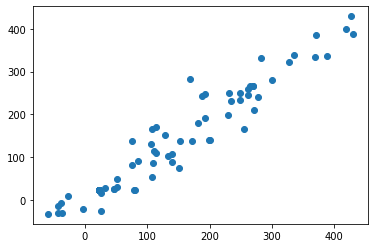

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(op_branch_1.cpu().detach().numpy(), op_branch_2.cpu().detach().numpy())

In [ ]:
plt.scatter(ytest_final[:,0], ytest_final[:,1])


IndexError: ignored

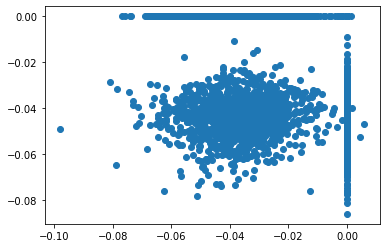

In [ ]:
plt.scatter(gen(torch.from_numpy(xtrain_final).float().to(cuda)).to('cpu:0').detach().numpy()[:,0], gen(torch.from_numpy(xtrain_final).float().to(cuda)).to('cpu:0').detach().numpy()[:,1])

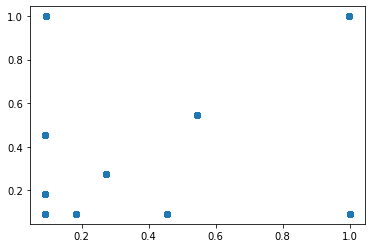

In [ ]:
plt.scatter(ytrain_final[:,0], ytrain_final[:,1])

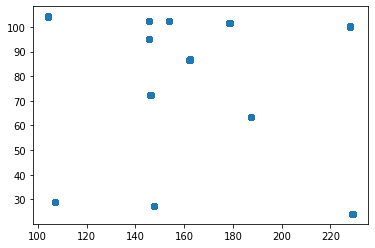

In [ ]:
plt.scatter(xtest_final[:,0],xtest_final[:,1])

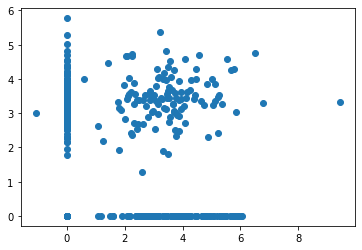

In [ ]:
plt.scatter(fake_compensated_points[:,3], fake_compensated_points[:,4])

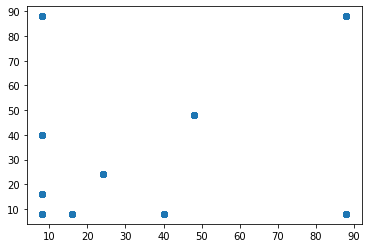

In [ ]:
plt.scatter(ytest_final[:,3], ytest_final[:,4])

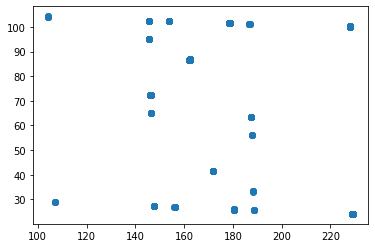

In [ ]:
plt.scatter(xtest_final[:,3],xtest_final[:,4])

In [ ]:
xyz.shape

NameError: ignored

In [ ]:
fake_compensated_points

In [ ]:
xtest

In [ ]:
ytest_final

In [ ]:
tr_opt=gen(torch.from_numpy(xtrain_final).float().to(cuda)).to('cpu:0').detach().numpy()

In [ ]:
#tensor_mse_calc(testx,normalizer(testy)).mean()
ytrain_final=ytrain_final*ytrain_max+ytrain_min
tr_opt=tr_opt*ytrain_max+ytrain_min

In [ ]:
xtrain_final_unnorm=xtrain_final*xtrain_max+xtrain_min

In [ ]:
mse_calc_(xtrain_final_unnorm,ytrain_final).mean()

In [ ]:
ytrain_final

In [ ]:
xtrain_final_unnorm

In [ ]:
mse_calc_(xtrain_final_unnorm,tr_opt).mean()